# Complete Notebook

## Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow import keras
from keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.models import Model
from tensorflow.keras.applications import DenseNet201
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline 

## Keeping Colab Alive 

function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}

var colab = setInterval(ConnectButton,60000);


clearInterval(colab)


## Downloading Dataset

In [3]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


if __name__ == "__main__":
    file_id = '1OOb7IoDxjvSjp-rqpr2w-caSmIgOCFA_'
    destination = 'dataset.zip'
    download_file_from_google_drive(file_id, destination)

## Unzipping Dataset

In [4]:
%%capture
!unzip dataset.zip

## Initializing Parameters

In [5]:
IMAGE_SIZE = [256, 256, 3]

train_path = 'Dataset/Train'
test_path = 'Dataset/Test'
val_path = 'Dataset/Val'

## Data Augmentation

In [6]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)




# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('Dataset/Train',
                                                 target_size = (256, 256),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')


test_set = test_datagen.flow_from_directory('Dataset/Test',
                                            target_size = (256, 256),
                                            batch_size = 32,
                                            class_mode = 'categorical')


val_set = test_datagen.flow_from_directory('Dataset/Val',
                                            target_size = (256, 256),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 3641 images belonging to 2 classes.
Found 455 images belonging to 2 classes.
Found 455 images belonging to 2 classes.


## DenseNet201

In [7]:
base_model_dense201 = DenseNet201(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False, pooling='max')

74842112/74836368 [==============================] - 1s 0us/step


In [8]:
for layer in base_model_dense201.layers:
    layer.trainable = False

## Building Model

In [9]:
x = base_model_dense201.output
x = Flatten()(x)

# x = Dense(1024, activation='relu')(x)
# x = Dropout(0.5)(x)
# prediction = Dense(2,activation = "sigmoid")(x)
# model_final = Model(base_model_eff0.input,prediction)

prediction = Dense(2, activation='softmax')(x)
final_model = Model(inputs=base_model_dense201.input, outputs=prediction)

In [10]:
final_model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [11]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

## Training

In [12]:
history = final_model.fit_generator(
  training_set,
  validation_data=val_set,
  epochs=100,
  steps_per_epoch=len(training_set),
  validation_steps=len(val_set)
)

Epoch 1/100
114/114 [==============================] - 182s 1s/step - loss: 0.2493 - accuracy: 0.8980 - val_loss: 0.0837 - val_accuracy: 0.9736
Epoch 2/100
114/114 [==============================] - 159s 1s/step - loss: 0.0622 - accuracy: 0.9791 - val_loss: 0.0690 - val_accuracy: 0.9780
Epoch 3/100
114/114 [==============================] - 160s 1s/step - loss: 0.0448 - accuracy: 0.9849 - val_loss: 0.0593 - val_accuracy: 0.9802
Epoch 4/100
114/114 [==============================] - 159s 1s/step - loss: 0.0405 - accuracy: 0.9825 - val_loss: 0.0474 - val_accuracy: 0.9846
Epoch 5/100
114/114 [==============================] - 160s 1s/step - loss: 0.0240 - accuracy: 0.9927 - val_loss: 0.0722 - val_accuracy: 0.9824
Epoch 6/100
114/114 [==============================] - 159s 1s/step - loss: 0.0236 - accuracy: 0.9925 - val_loss: 0.0459 - val_accuracy: 0.9868
Epoch 7/100
114/114 [==============================] - 159s 1s/step - loss: 0.0276 - accuracy: 0.9892 - val_loss: 0.0418 - val_accuracy:

## Testing

In [13]:
print("Evaluating on test data ....")
results = final_model.evaluate(test_set, batch_size=32)
print("test loss, test acc:", results)

Evaluating on test data ....
15/15 [==============================] - 21s 1s/step - loss: 0.0313 - accuracy: 0.9934
test loss, test acc: [0.031337566673755646, 0.9934065937995911]


## Plotting 

In [14]:
history.history

{'loss': [0.15038372576236725,
  0.05988312140107155,
  0.041762229055166245,
  0.03382375091314316,
  0.027234384790062904,
  0.024050014093518257,
  0.02238861657679081,
  0.024717366322875023,
  0.01927773468196392,
  0.018302446231245995,
  0.02327604778110981,
  0.01893014833331108,
  0.021672530099749565,
  0.01366215106099844,
  0.013447660021483898,
  0.018049363046884537,
  0.013237487524747849,
  0.009594176895916462,
  0.014760760590434074,
  0.010642001405358315,
  0.011501725763082504,
  0.013435998931527138,
  0.011572974734008312,
  0.0097403135150671,
  0.011013171635568142,
  0.012831712141633034,
  0.011246913112699986,
  0.02298547700047493,
  0.012028450146317482,
  0.020174406468868256,
  0.010401083156466484,
  0.012142912484705448,
  0.009439537301659584,
  0.009960856288671494,
  0.012112378142774105,
  0.010490008629858494,
  0.051472343504428864,
  0.00919581949710846,
  0.007083455566316843,
  0.006206311285495758,
  0.006909630727022886,
  0.0067145908251404

### Accuracy vs Epochs

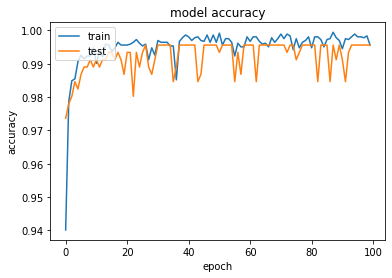

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


### Loss vs Epochs

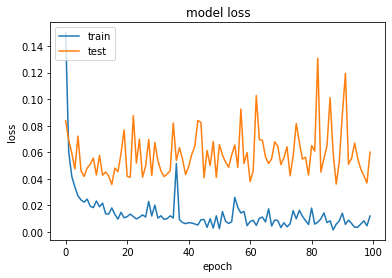

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()